# 1. Understand the environment

Observation space: State consists of hull angle speed, angular velocity, horizontal speed,vertical speed, position of joints and joints angular speed, legs contact with ground, and 10 lidar rangefinder measurements. There are no coordinates in the state vector.

Action space: 4 motor speed values in the [-1, 1] range for each joints at each hip and each knee. Clipped if out of range.

Rewards: Reward is given for moving forward, totaling 300+ points up to the far end. If the robot falls, it gets -100. Applying motor torque costs a small amount of points.
    
Starting State: The walker starts standing at the left end of the terrain with the hull horizontal, and both legs in the same position with a slight knee angle.

Episode Termination: The episode will terminate if the hull gets in contact with the ground or if the walker exceeds the right end of the terrain length.

Solved: To solve the normal version, you need to get 300 points in 1600 time steps. To solve the hardcore version, you need 300 points in 2000 time steps.

To use to the _hardcore_ environment, you need to specify env = gym.make("BipedalWalker-v3", hardcore=True)

# 2. Imports and prequesites

In [106]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 3. Test the environment

In [107]:
env = gym.make('BipedalWalker-v3')
print('Start state:', env.reset())
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)
print('Example action:', env.action_space.sample())
print('Example item in action:', env.action_space.sample()[0])
print('Step:', env.step([0, 0, 0, 0]))

Start state: [ 2.7468470e-03  4.5991310e-06 -5.9967121e-04 -1.6000031e-02
  9.2298917e-02  1.3920880e-03  8.5999680e-01  2.9629850e-04
  1.0000000e+00  3.2665018e-02  1.3920561e-03  8.5363185e-01
 -9.4726542e-04  1.0000000e+00  4.4081357e-01  4.4581968e-01
  4.6142232e-01  4.8954970e-01  5.3410226e-01  6.0246044e-01
  7.0914817e-01  8.8593090e-01  1.0000000e+00  1.0000000e+00]
Observation space: Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf], (24,), float32)
Action space: Box([-1. -1. -1. -1.], [1. 1. 1. 1.], (4,), float32)
Example action: [-0.60288626  0.5241112  -0.32895938  0.8959497 ]
Example item in action: 0.9201131
Step: (array([-5.2367235e-03,  1.1666132e-05, -4.2310990e-03, -1.3064843e-03,
        4.3597302e-01,  6.7821614e-02,  1.1452216e-01, -8.4761836e-02,
        1.0000000e+00,  3.3870354e-01,  7

# 4. Define the neural network

In [128]:
class Network(nn.Module):
    def __init__(self, s_size, h_size, a_size):
        super(Network, self).__init__() 
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = F.softmax(self.fc2(x), dim=1)
        sigma = F.softplus(self.fc2(x))
        return mu, sigma
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) 
        mu, sigma = self.forward(state) 
        
        d = Normal(mu, sigma)
        action = []
        
        a1 = d.sample()
        action.append(a1.numpy()[0][0])
        m1 = d.log_prob(a1)
        
        a2 = d.sample()
        action.append(a2.numpy()[0][0])
        m2 = d.log_prob(a2)
        
        a3 = d.sample()
        action.append(a3.numpy()[0][0])
        m3 = d.log_prob(a3)
        
        a4 = d.sample()
        action.append(a4.numpy()[0][0])
        m4 = d.log_prob(a4)
        
        log_prob = m1 + m2 + m3 + m4
        
        return action, log_prob

# 5. Instantiate the neural network¶

In [129]:
policy = Network(s_size = 24, h_size = 64, a_size = 1).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

# 6. Define the algorithm to be used

In [130]:
def reinforce(n_episodes=100, gamma=1.0, print_every=10):

    scores = [] 
    scores_deque = deque(maxlen=print_every)    

    for i_episode in range(1, n_episodes+1):
        
        state = env.reset()
        terminal = False
        discounted_rewards = []
        saved_log_probs = [] 
        step = 1
        
        while not terminal:
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            
            discounted_reward = reward*(gamma**step)
            discounted_rewards.append(discounted_reward)

            if done == True: 
                terminal = True
            else:
                step = step + 1   
        
        G = sum(discounted_rewards)
        scores_deque.append(G)
        scores.append(G)
        rewards_togo = []
        for i in range(step): 
            rewards_togo.append(sum(discounted_rewards))
            discounted_rewards.pop(0)
        
        policy_loss = []
        
        for i in range(step): 
            policy_loss.append(-saved_log_probs[i] * rewards_togo[i])
        
        policy_loss = torch.cat(policy_loss).sum() 
        optimizer.zero_grad() 
        policy_loss.backward() 
        optimizer.step()
        
        if i_episode % print_every == 0: 
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        if scores[i_episode-1] >=300.0 and step <= 1600:
            print('Environment solved in {:d} episodes!'.format(i_episode,))
            return scores
            
    return scores

# 7. Train the agent

In [131]:
scores = reinforce()

Episode 10	Average Score: -115.96
Episode 20	Average Score: -115.12
Episode 30	Average Score: -115.88
Episode 40	Average Score: -116.99
Episode 50	Average Score: -116.33
Episode 60	Average Score: -114.30
Episode 70	Average Score: -115.32
Episode 80	Average Score: -116.45
Episode 90	Average Score: -115.15
Episode 100	Average Score: -115.74


# 8. Plot rewards over episodes

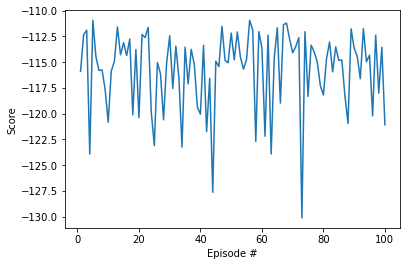

In [132]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# 9. Test the trained agent

In [133]:
env = gym.make('BipedalWalker-v3')

for i in range(10):
    state = env.reset()
    terminal = False
    step = 1
    ep_reward = 0

    while not terminal:
        env.render()
        action, _ = policy.act(state)
        state, reward, done, _ = env.step(action)
        ep_reward = ep_reward + reward 
        print(step)
        print(action)
        print(reward)
        if done == True: 
            terminal = True
        else: 
            step = step + 1
    
    print('Episode reward:', ep_reward)
    
env.close()

2022-04-21 02:48:50.402 python[31650:4803365] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fed7d463e00>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 02:48:50.403 python[31650:4803365] Warning: Expected min height of view: (<NSButton: 0x7fed7d4bb2d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 02:48:50.406 python[31650:4803365] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fed7ad10900>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 02:48:50.409 python[31650:4803365] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fed7d4bbe30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


1
[0.90349823, 0.9289628, 0.69433105, 1.0559427]
-0.08771211619116365
2
[1.1186112, 1.1740932, 1.2386928, 0.7415617]
-0.5037030977706092
3
[1.0194396, 1.0753453, 1.4327282, 1.1661443]
-0.4724545568426475
4
[0.93129236, 0.9914841, 0.7737885, 0.74182737]
-0.5051225659052507
5
[1.4540329, 0.39360517, 0.8453607, 1.3913478]
-0.5453385903437956
6
[0.8464173, 0.52108175, 1.2641356, 1.2721777]
-0.5034780851205178
7
[0.93399304, 1.161084, 1.0735053, 0.7789688]
-0.5115592120488474
8
[0.5491552, 1.2180476, 1.0382794, 0.8420584]
-0.5034161176681519
9
[0.63154155, 1.085383, 1.122796, 0.8438512]
-0.4837531816959382
10
[1.0085047, 1.2673525, 0.624969, 1.033278]
-0.48079714361826703
11
[0.9056926, 1.1978348, 1.209511, 0.88418865]
-0.4895388703346253
12
[0.7899156, 0.96636015, 1.1098269, 0.81423]
-0.48534872825940334
13
[1.2070485, 1.340027, 1.0536778, 1.0252364]
-0.5025921777089462
14
[1.0028517, 1.3721315, 1.2640173, 0.82162684]
-0.4978235712846109
15
[0.93308717, 1.0372791, 1.0712936, 1.130113]
-0.4

# Debug

In [127]:
env = gym.make('BipedalWalker-v3')

for i in range(10):
    state = env.reset()
    terminal = False
    step = 1
    ep_reward = 0

    while not terminal:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        print(step)
        print(action)
        print(reward)
        ep_reward = ep_reward + reward 

        if done == True: 
            terminal = True
#         elif step >= 200:
#             terminal = True
        else: 
            step = step + 1
            
    print('Episode reward:', ep_reward)
    
env.close()

2022-04-21 02:48:08.061 python[31650:4803365] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fed7ad7d0d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 02:48:08.061 python[31650:4803365] Warning: Expected min height of view: (<NSButton: 0x7fed7ca08820>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 02:48:08.065 python[31650:4803365] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fed7ca08fb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-21 02:48:08.067 python[31650:4803365] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fed7ad7ec20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


1
[ 0.84725815  0.08869731  0.85172915 -0.32622996]
-0.2300112350663803
2
[ 0.7659076   0.7276399   0.13518724 -0.82044166]
-0.2226296369681732
3
[-0.9063121  -0.23365867  0.8285663   0.7618855 ]
-0.21612272803982335
4
[-0.391899   -0.37565583  0.78530157  0.55965495]
-0.2272321746945381
5
[ 0.69126683 -0.01529626 -0.85199875 -0.32369998]
-0.17901333429043373
6
[0.94285494 0.5429772  0.22185399 0.5389687 ]
-0.28171362753709034
7
[ 0.92182946  0.96892047  0.31847632 -0.30468214]
-0.30948080631097397
8
[ 0.7732846   0.5865579   0.7792037  -0.99866396]
-0.33081073617935186
9
[ 0.00920556  0.49687803 -0.9787732  -0.2581808 ]
-0.18939187490567566
10
[-0.9733733  -0.30558687 -0.62743205 -0.607968  ]
-0.05067523272832117
11
[ 0.20811114 -0.8445721  -0.9155877  -0.73885006]
-0.05727252717812738
12
[-0.43232682  0.55062246 -0.12784511 -0.40783125]
0.002941964427627744
13
[ 0.17351252  0.6372052  -0.66719335 -0.3144004 ]
-0.07814957114060601
14
[-0.6726809   0.01868939 -0.69719404  0.7041869 ]
0